# MorphCT Example Workflow

1. Start with an atomistic snapshot
2. Determine which atom indices belong to which chromophore using [SMARTS](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) matching
3. Calculate the energies for each chromophore and chromophore pair using quantum chemical calculations (QCC)
4. Run the kinetic monte carlo (KMC) algorithm to calculate charge mobility

First let's import necessary modules:

In [1]:
from copy import deepcopy
import os
import multiprocessing as mp

import gsd.hoomd
import matplotlib.pyplot as plt
import mbuild as mb
import numpy as np

from morphct import execute_qcc as eqcc
from morphct import mobility_kmc as kmc
from morphct import chromophores
from morphct import kmc_analyze
from morphct.chromophores import amber_dict

# A couple functions useful for visualization are included in a .py file in this directory 
from ex_scripts import visualize_qcc_input, from_snapshot

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


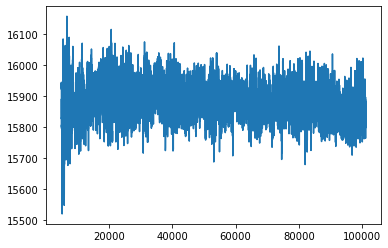

In [2]:
data = np.loadtxt("/Users/jenny/remote/itic/workspace/d7687eaebb9d2501e3a9c2dcaedc38f5/trajectory.log")
timestep = data[500:,0]
potential = data[500:,4]
plt.plot(timestep,potential)
plt.show()

Here's our starting structure, an atomistic (not coarse-grain or united atom) gsd file with 2 p3ht 15-mers:

In [3]:
with gsd.hoomd.open(name="../itic-trajectory.gsd", mode="rb") as f:
    snap = f[0]

# It is expected that the snapshot is in the Angstrom length scale.
# If not, it can be scaled as follows (set `scale` equal to the scaling factor)
scale = 3.563594872561358
snap.particles.position *= scale
snap.configuration.box[:3] *= scale

# These lines are only necessary to visualize the snapshot
box = snap.configuration.box[:3]
unwrapped_positions = snap.particles.position + snap.particles.image * box
unwrap_snap = deepcopy(snap)
unwrap_snap.particles.position = unwrapped_positions
unwrap_snap.particles.types = [amber_dict[i].symbol for i in snap.particles.types]
comp = from_snapshot(unwrap_snap, scale=0.1) # convert to nm
comp.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

For two 15-mers with each monomer being a chromophore, we expect 30 chromophores. Basically, the smarts matching misses one chromophore. So I have to add it manually. 

The visualization below shows the detected chromophores in pink and the missed one in blue:

In [4]:
a_inds = [np.arange(19), np.hstack((np.array([166]), np.arange(168,186)))]

d_inds = np.hstack(
    (np.array([20]), np.arange(22,33),np.arange(91,103),np.arange(161,165))
)


mol_length = 186
n_mols = snap.particles.N // mol_length
ac_inds = [
    item for sublist in 
    [(a_inds[0] + i * mol_length, a_inds[1] + i * mol_length) for i in range(n_mols)]
    for item in sublist
]

do_inds = [d_inds + i * mol_length for i in range(n_mols)]

for i,p in enumerate(comp.particles()):
    if i in np.hstack(ac_inds):
        p.name = "Kr"
    if i in np.hstack(do_inds):
        p.name = "N"
comp.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Next let's make a Chromophore object for each detected chromophore and add them to a list:

In [5]:
chromo_list = []
for i, ac_ind in enumerate(ac_inds):
    chromo_list.append(chromophores.Chromophore(i, snap, ac_ind, "acceptor", amber_dict))

for i, do_ind in enumerate(do_inds):
    chromo_list.append(chromophores.Chromophore(i, snap, do_ind, "donor", amber_dict))

Next let's compute (using voronoi analysis) which chromophores are neighbors. `qcc_pairs` is a list containing the indices of the pair and the pair's qcc input: `((i,j), qcc_input)`


In [6]:
qcc_pairs = chromophores.set_neighbors_voronoi(
    chromo_list, snap, amber_dict, d_cut=min(box)/2
)
print(f"There are {len(qcc_pairs)} chromophore pairs")

There are 138 chromophore pairs


Before running any QCC we can check that the pair and singles inputs look reasonable. There won't be any bonds and hydrogen atoms should've been added.

In [31]:
i = 72 # try any number from 0 to 137
print(f"Pair #{i}:")
visualize_qcc_input(qcc_pairs[i][1])

i = 0 # try any number from 0 to 10
print(f"Single #{i}:")
visualize_qcc_input(chromo_list[i].qcc_input)

Pair #72:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Single #0:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Next we need to get the single and pair energies which will be used in the QCC calculations. These take a little time, so these functions are designed to save to a file. We'll first make the directory and define the filenames.

In [24]:
outpath = os.path.join(os.getcwd(), "output")
if not os.path.exists(outpath):
    os.makedirs(outpath)
s_filename = os.path.join(outpath, "singles_energies.txt")
d_filename = os.path.join(outpath, "dimer_energies.txt")

MorphCT uses multiprocessing to run calculations in parallel.

`eqcc.get_homolumo(chromo_list[0].qcc_input)` operates on one chromophore and returns HOMO-1, HOMO, LUMO, LUMO+1

`eqcc.singles_homolumo` does this for all chromophores and saves the energies to a file.

In [ ]:
%%time
data = eqcc.singles_homolumo(chromo_list, s_filename)

# Approx time required:
# CPU times: user 20.9 ms, sys: 30.1 ms, total: 51 ms
# Wall time: 6.05 s

Next let's compute the pair energies:

In [ ]:
%%time
dimer_data = eqcc.dimer_homolumo(qcc_pairs, d_filename)

# Approx time required:
# CPU times: user 20.3 ms, sys: 27.2 ms, total: 47.6 ms
# Wall time: 56.6 s

Once the energy files are finsihed, we can use them to set the energy values of the chromophores in the list

In [ ]:
eqcc.set_energyvalues(chromo_list, s_filename, d_filename)

This function sets the homo_1, homo, lumo, lumo_1, neighbors_delta_e, and neighbors_ti of each chromphore.

In [ ]:
i = 0
chromo = chromo_list[i]
print(f"Chromophore {i}:")
print(
    f"HOMO-1: {chromo.homo_1:.2f} HOMO: {chromo.homo:.2f} LUMO: {chromo.lumo:.2f} "
    f"LUMO+1: {chromo.lumo_1:.2f}"
)
print(f"{len(chromo.neighbors)} neighbors")
print(f"DeltaE of first neighbor: {chromo.neighbors_delta_e[0]:.3f}")
print(f"Transfer integral of first neighbor: {chromo.neighbors_ti[0]:.3f}")

With all the energy values set, we're ready to run KMC! First we'll make a directory:

In [ ]:
kmc_dir = os.path.join(outpath, "kmc")
if not os.path.exists(kmc_dir):
    os.makedirs(kmc_dir)

Next we'll run kmc on a random list of jobs in parallel using multiprocessing:

In [ ]:
lifetimes = [1.00e-13, 1.00e-12]
temp = 300
combined_data = kmc.run_kmc(
    lifetimes, kmc_dir, chromo_list, snap, temp, n_holes=10, verbose=1
)

The output files for each process are saved in `output/kmc/kmc_PROC#.log` (where `PROC#` is whatever process number the job was run on):

In [ ]:
with open(os.path.join(kmc_dir, "kmc_00.log"), "r") as f:
    lines = f.readlines()
print(*lines)

Finally we can analyze our results -- plots will be saved in `output/kmc/figures/`

In [ ]:
kmc_analyze.main(combined_data, temp, chromo_list, snap, kmc_dir)